In [1]:
%pylab inline
import summa_plot as sp
import pysumma.Simulation
import importlib
import time
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
import itertools
import pandas as pd
from functools import reduce
from scipy.special import psi
from sklearn.neighbors import NearestNeighbors


def raw_data(data_array):
    """Unpacks data into a flat array"""
    return data_array.values.flatten()


def good_inds(x):
    """Remove invalid data"""
    return np.where(np.logical_and(x > -3000, x < 3000))[0]


def nearest_distances(X, k=1):
    """Compute distances to kth nearest neighbors"""
    knn = NearestNeighbors(n_neighbors=k, metric='chebyshev')
    knn.fit(X)
    d, _ = knn.kneighbors(X)
    return d[:, -1]


def marginal_neighbors(X, R):
    """Compute number of neighbors in R-radius ball"""
    knn = NearestNeighbors(metric='chebyshev')
    knn.fit(X)
    return [len(knn.radius_neighbors(p.reshape(1, -1), r)[0][0])
            for p, r in zip(X, R)]


def entropy_sk(X, k=False):
    """Compute entropy H(X1, X2,..., Xn)"""
    try:
        n, d = X.shape
    except Exception as e:
        X = X.reshape(-1, 1)
        n, d = X.shape
    if not k:
        k = 10
    eps = 1e-12
    r = nearest_distances(X, k) + eps * np.random.random(n)
    n, d = X.shape
    ent = d * np.log(np.mean(r)) + psi(n) - psi(k) + d * np.log(2)
    return ent


def mutual_info(x, y, k=False):
    """Compute I(X; Y)"""
    n = len(x)
    if not k:
        k = 10
    eps = 1e-12
    r = nearest_distances(np.array([x, y]).T[0], k) - eps * np.random.random(n)
    psi_x = psi(marginal_neighbors(x, r))
    psi_y = psi(marginal_neighbors(y, r))
    return (psi(n) + psi(k) - (1./k) - np.mean(psi_x + psi_y))


def conditional_mutual_info(X, k=False):
    """Compute I(X1; X2 | X3:n)"""
    xz = np.array([X[0], *X[2:]]).T
    yz = np.array([X[1], *X[2:]]).T
    z = np.array(X[2:]).T
    d, n = X.shape
    if not k:
        k = 10
    eps = 1e-12
    r = nearest_distances(X.T, k) + eps * np.random.random(n)
    psi_xz = psi(marginal_neighbors(xz, r))
    psi_yz = psi(marginal_neighbors(yz, r))
    psi_z = psi(marginal_neighbors(z, r))
    return (psi(k) - np.mean(psi_xz + psi_yz - psi_z))


def transfer_entropy(X: np.array, lag: int) -> float:
    """
    Computes TE(X1_t; X2_{t-lag} | X3:n_{t-lag}, X1_{t-lag})

    Args:
        X: A list containing multiple timeseries.
           Example: [evap, precip, runoff] will compute
           the information transferred from precip to evap,
           eliminating any effects from runoff.
        lag: The time-offset to consider (in days).

    Returns:
        The value of the equation given above.  Small values
        denote less of a connection.  Negative values are
        possible, but should be thrown out - as they are
        numerical artifacts.
    """
    # Need at least 3 variables to compute the TE
    assert len(X) > 2
    # Subsample data and put it together with combination list
    sample_size = np.min([2000, len(X[0])-lag])
    max_start = len(X[0]) - sample_size - lag
    idx = np.random.choice(np.arange(len(X[0])) - lag, sample_size)
    ans = [X[0][idx]]
    for v in X[1:]:
        ans.append(v[idx-lag])
    ans.append(X[0][idx-lag])
    return conditional_mutual_info(np.array(ans))


In [ ]:
def postprocess(ds):
    """
    Aggregate subcomponents and convert units for the
    output variables of interest. This also removes
    the unnecessary hru dimension
    """
    for k, v in wb_dict.items():
        ds[k] = reduce(operator.add, [ds[vv] for vv in v]) * wb_multiplier[k]
    ds = ds[list(wb_dict.keys())].isel(hru=0, drop=True)
    ds['dswe'] = ds['swe'].diff(dim='time')
    ds['dsoil_moisture'] = ds['soil_moisture'].diff(dim='time')
    return ds

def create_sim_obj(site):
    """
    Create the simulation object for a particular
    location and set the necessary output variables
    """
    s = pysumma.Simulation.Simulation(fman_dict[site])
    s.executable = '/opt/local/bin/summa.exe'
    s.library_path = '$HOME/software/lib:/opt/local/lib:/opt/local/lib64:$LD_LIBRARY_PATH'
    o = s.output_control
    for v in wb_vars:
        o.set_option(v, 1)
    o.write()
    return s

def run_summa(site):
    """Kick off a SUMMA simulation for a given location"""
    s = create_sim_obj(site)
    additional_args = ['export OMP_NUM_THREADS=8']
    return s.execute('test', 'local', additional_args)

def monitor(proc):
    """Watch the SUMMA simulation until it has completed"""
    while proc.poll() is not None:
        time.sleep(1)
    return proc.stdout.read(), proc.stderr.read()

def set_decision(simulation, decision_key, decision_value):
    """Change a decision"""
    simulation.decision_obj.__dict__[decision_key].value = decision_value

In [16]:
path = '/pool0/data/tushark/PLUMBER_data/sites/Hyytiala/summa_output/Hyytiala_output_test_simpleResistance_timestep.nc'

In [17]:
hyytiala = xr.open_dataset(path)

In [18]:
var1 = hyytiala['pptrate']

In [19]:
var2 = hyytiala['scalarSWE']

In [20]:
var3 = hyytiala['airtemp']

In [13]:
lists = np.array([var1, var2, var3])
lists

KeyboardInterrupt: 

In [ ]:
transfer_entropy(lists, 1)

/pool0/home/tushark/miniconda3/envs/default/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


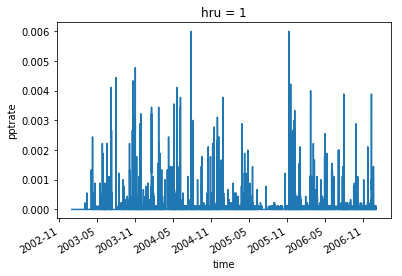

In [10]:
var1.plot()

In [12]:
run = entropy_sk(var1)

In [17]:
var1.shape

(70128, 1)

In [30]:
var7 = raw_data(var1.isel(time=slice(0, 365*24)))

In [26]:
entropy_sk(var7,k=300)

-7.8537042273284516

In [27]:
sum(nearest_distances(var7))

0.0

In [31]:
var5 = raw_data(var2.isel(time=slice(0, 365*24)))

In [32]:
mutual_info(var5, var7)

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.  0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [33]:
var6 = raw_data(var3.isel(time=slice(365*24)))

In [36]:
lists = np.array([var4, var5, var6])

In [37]:
conditional_mutual_info(lists)

ValueError: not enough values to unpack (expected 2, got 1)

In [38]:
lists.shape

(3,)

In [46]:
var7 = var1.isel(hru=0,drop=True,time=slice(0, 12*24*100))
var8 = var2.isel(hru=0,drop=True,time=slice(0, 12*24*100))
var9 = var3.isel(hru=0,drop=True,time=slice(0, 12*24*100))
nlists = np.array([var7, var8, var9])

In [47]:
nlists.shape

(3, 28800)

In [48]:
conditional_mutual_info(nlists)

-0.088133844992368093

In [49]:
transfer_entropy(nlists,lag=20)

-0.028769804210979188

In [50]:
lags = list(range(0, 24 * 365, 24))

In [51]:
def transfer_test(nlist, lags):
    result = []
    for l in lags:
        result.append(transfer_entropy(nlist, l))
    return result

In [52]:
test = transfer_test(nlists, lags)

In [60]:
test.plot()

AttributeError: 'list' object has no attribute 'plot'

In [38]:
import matplotlib as plt

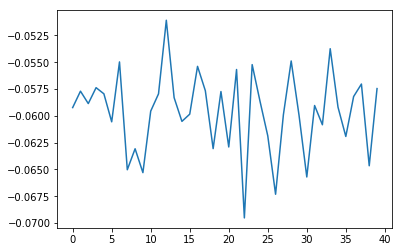

In [42]:
plt.pyplot.plot(test)

In [54]:
fman_template = "/pool0/data/tushark/PLUMBER_data/sites/{}/settings/summa_zFileManager_{}.txt"

In [56]:
path1 = fman_template.format('Amplero', 'Amplero')

In [57]:
path1

'/pool0/data/tushark/PLUMBER_data/sites/Amplero/settings/summa_zFileManager_Amplero.txt'

In [9]:
def transfer_plot(nlist, lags):
    result = []
    for l in lags:
        result.append(transfer_entropy(nlist, l))
    plt.pyplot.plot(result)

def plot_transfer_entropy(output_list, var1, var2, var3):
    path_prefix = "/pool0{}"
    lags = list(range(0, 24 * 365, 24))
    for output in output_list:
        path = path_prefix.format(output)
        site_data = xr.open_dataset(output)
        variable1 = site_data[var1]
        variable2 = site_data[var2]
        variable3 = site_data[var3]
        nlist = np.array([variable1, variable2, variable3])
        print(s)
        print('\n')
        transfer_plot(nlist, lags)
        print('\n')
        
sites = ['Amplero', 'Blodgett', 'Bugac', 'ElSaler', 'ElSaler2', 'Espirra', 'FortPeck', 
         'Harvard', 'Hesse', 'Howard', 'Howlandm', 'Hyytiala', 'Kruger', 'Loobos', 'Merbleue',
         'Mopane', 'Palang', 'Sylvania', 'Tumba', 'UniMich']

In [3]:
o_list = ['/data/tushark/PLUMBER_data/sites/Amplero/summa_output/Amplero_output_test_three_combinations_timestep.nc',
 '/data/tushark/PLUMBER_data/sites/Blodgett/summa_output/Blodgett_output_test_three_combinations_timestep.nc']

In [4]:
path = '/pool0' + o_list[0]

In [6]:
def postprocess(ds):
    """
    Aggregate subcomponents and convert units for the
    output variables of interest. This also removes
    the unnecessary hru dimension
    """
    for k, v in wb_dict.items():
        ds[k] = reduce(operator.add, [ds[vv] for vv in v]) * wb_multiplier[k]
    return ds[list(wb_dict.keys())].isel(hru=0, drop=True)

In [7]:
amplero = postprocess(xr.open_dataset(oath))
amplero

NameError: name 'oath' is not defined

In [16]:
site_data = xr.open_dataset(path)
variable1 = site_data[var1]
variable2 = site_data[var2]
variable3 = site_data[var3]
nlist = np.array([variable1, variable2, variable3])
print(s)
print('\n')
transfer_plot(nlist, lags)
print('\n')

IndexError: The indexing operation you are attempting to perform is not valid on netCDF4.Variable object. Try loading your data into memory first by calling .load().